# Main Notebook
***

Author: [Matthew Reinhart](https://www.linkedin.com/in/matthew-reinhart-1bb372173/)

## Overview 
***

The sports gambling industry is one of the fastest growing in America today. You cannot turn the television on to any sports channel without seeing an advertisement for one of the big sportsbooks. Whether it be Draftkings, FanDuel, BetMGM, Caesaers, Pointsbet or Barstool the list goes on and on and the industry is only going to keep growing on a more national stage as more and more states move to legalize it. There is one sport that is widely considered the most difficult to bet on and predict within this industry and that is Major League Baseball. In a season with 162 games where powerhouses regularly lose to teams they are considered to be far superior to it can be awfully difficult to figure out who to bet on and to turn a profit. As [GamblingSites](https://www.gamblingsites.org/blog/6-sports-ranked-from-easiest-to-hardest-to-bet-on/) hardest sports to bet on ranking says, "Coming in as the most complicated sport to bet on is baseball. While I love betting on America’s pastime, it’s known to be the most demanding sport to win money. Baseball, unlike other major sports, is by far the most unpredictable sport to gamble on." 

## Objective
***

In the world of this project I am offering a better way to bet Major League Baseball. I offer sports bettors a path to making a more profit betting the most unpredictable sport.
In order to maximize returns, I ran a series of machine learning algorithms to model predictions for single games in a given MLB season. Accuracy is paramount in selecting our models, as we strive to minimize risk for our customers.

## Data
***

The data is mainly from [Sportsipy](https://sportsreference.readthedocs.io/en/stable/mlb.html?highlight=MLB) with insights from [Baseball-Referance](https://www.baseball-reference.com/) as well

## Methodology
***

I set the win/loss outcome for the home team as the binary target variable, with 1 equaling a win for the home team and 0 equaling a win for the away team.

After that I used an iterative approach to build 6 predictive, classification models: Logistic regression, K-Nearest Neighbors, Decision Tree, Random Forest, Bagging classifier and XGBoost. We utilize hyperparameter tuning, cross-validation and scoring to select the highest performing, predictive models. This approach is applied to regular season as well as post season data.

# Data Cleaning
***

The predictions are going to be based off the season average stats of the two relevant teams in each game. In order to get this I have to calculate the averages from all the games they played up to that point in the season, and make a new dataframe for the specific game with averages as input.

I need to make sure I have a clean dataframe with a clear target column of home win with a binary outcome of 1 or 0. Once I have a target column, I can create a dataframe with full seasons worth of games with that target column, and train our model on it.

In [2]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from datetime import datetime
from sportsipy.mlb.boxscore import Boxscore
from sportsipy.mlb.boxscore import Boxscores
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import modeling and data collection functions .py files
import sys
sys.path.append("../")
from Modeling_functions import *
from data_collection_functions import *

In this notebook I will walk you through what was done for a specific year 2019. However, over the course of this project this process was done for years 2016-2021. In order to get the year you would desire all that would need to be done is simply changing the dates to the desired timeframe and going about the process in the same manner.

In [69]:
# Function to return games in certain time range
def get_current_games(date,end_date,end_week=None):
    
    games = Boxscores(date,end_date)
    schedule = games.games

    game_days = []
    for day in schedule.values():
        for game in day:
            game_days.append(game['boxscore'])
            
    season_games = []

    for i in game_days:
        temp = Boxscore(i).dataframe
        season_games.append(temp)

    df = pd.concat(season_games, axis = 0).reset_index()

    return df

Enter start and end date wanted in this case we will look at the 2019 regular season which spans from March 3rd until September 29th.

In [3]:
df=get_current_games(datetime(2019, 3, 28),datetime(2019, 9, 29))

In [4]:
df.head()

,index,date,time,venue,attendance,duration,time_of_day,winner,winning_name,winning_abbr,...,home_strikes_looking,home_grounded_balls,home_fly_balls,home_line_drives,home_unknown_bat_type,home_game_score,home_inherited_runners,home_inherited_score,home_win_probability_by_pitcher,home_base_out_runs_saved
0,NYA/NYA201903280,"Thursday, March 28, 2019",1:12 p.m. Local,Yankee Stadium III,46928,3:06,Day,Home,New York Yankees,NYY,...,35,9,13,4,0,56,1,0,0.240,2.9
1,WAS/WAS201903280,"Thursday, March 28, 2019",1:07 p.m. Local,Nationals Park,42263,2:44,Day,Away,New York Mets,NYM,...,24,5,12,8,0,76,3,1,0.226,3.1
2,MIL/MIL201903280,"Thursday, March 28, 2019",1:10 p.m. Local,Miller Park,45304,2:36,Day,Home,Milwaukee Brewers,MIL,...,28,14,11,3,0,55,1,0,0.321,0.8
3,PHI/PHI201903280,"Thursday, March 28, 2019",3:08 p.m. Local,Citizens Bank Park,44469,3:04,Day,Home,Philadelphia Phillies,PHI,...,22,13,9,0,0,67,0,0,0.230,0.9
4,TOR/TOR201903280,"Thursday, March 28, 2019",4:08 p.m. Local,Rogers Centre,45048,2:25,Day,Away,Detroit Tigers,DET,...,16,9,16,5,0,76,0,0,0.310,3.4


In [5]:
# Look at the given columns
df.columns

Index(['index', 'date', 'time', 'venue', 'attendance', 'duration',
       'time_of_day', 'winner', 'winning_name', 'winning_abbr', 'losing_name',
       'losing_abbr', 'away_at_bats', 'away_runs', 'away_hits', 'away_rbi',
       'away_earned_runs', 'away_bases_on_balls', 'away_strikeouts',
       'away_plate_appearances', 'away_batting_average',
       'away_on_base_percentage', 'away_slugging_percentage',
       'away_on_base_plus', 'away_pitches', 'away_strikes',
       'away_win_probability_for_offensive_player',
       'away_average_leverage_index', 'away_win_probability_added',
       'away_win_probability_subtracted', 'away_base_out_runs_added',
       'away_putouts', 'away_assists', 'away_innings_pitched',
       'away_home_runs', 'away_strikes_by_contact', 'away_strikes_swinging',
       'away_strikes_looking', 'away_grounded_balls', 'away_fly_balls',
       'away_line_drives', 'away_unknown_bat_type', 'away_game_score',
       'away_inherited_runners', 'away_inherited_score',


In [6]:
# Look at Dtypes and more info about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 82 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   index                                      2427 non-null   object 
 1   date                                       2427 non-null   object 
 2   time                                       2427 non-null   object 
 3   venue                                      2427 non-null   object 
 4   attendance                                 2415 non-null   object 
 5   duration                                   2427 non-null   object 
 6   time_of_day                                2427 non-null   object 
 7   winner                                     2427 non-null   object 
 8   winning_name                               2427 non-null   object 
 9   winning_abbr                               2427 non-null   object 
 10  losing_name             

In [11]:
#set date to datetime
df.date=pd.to_datetime(df.date)

In [12]:
#Set date as index
df.set_index(df.date,inplace=True)

In [13]:
#Get rid of possible whitespace issues
for column in df.columns:
    column.strip()

In [14]:
#drop no longer needed columns, index not needed and date currently in index
df.drop(['index','date'],axis=1,inplace=True)

In [15]:
#Examine df as currently constructed
df.head()

,time,venue,attendance,duration,time_of_day,winner,winning_name,winning_abbr,losing_name,losing_abbr,...,home_strikes_looking,home_grounded_balls,home_fly_balls,home_line_drives,home_unknown_bat_type,home_game_score,home_inherited_runners,home_inherited_score,home_win_probability_by_pitcher,home_base_out_runs_saved
date,,,,,,,,,,,,,,,,,,,,,
2019-03-28,1:12 p.m. Local,Yankee Stadium III,46928,3:06,Day,Home,New York Yankees,NYY,Baltimore Orioles,BAL,...,35,9,13,4,0,56,1,0,0.240,2.9
2019-03-28,1:07 p.m. Local,Nationals Park,42263,2:44,Day,Away,New York Mets,NYM,Washington Nationals,WSN,...,24,5,12,8,0,76,3,1,0.226,3.1
2019-03-28,1:10 p.m. Local,Miller Park,45304,2:36,Day,Home,Milwaukee Brewers,MIL,St. Louis Cardinals,STL,...,28,14,11,3,0,55,1,0,0.321,0.8
2019-03-28,3:08 p.m. Local,Citizens Bank Park,44469,3:04,Day,Home,Philadelphia Phillies,PHI,Atlanta Braves,ATL,...,22,13,9,0,0,67,0,0,0.230,0.9
2019-03-28,4:08 p.m. Local,Rogers Centre,45048,2:25,Day,Away,Detroit Tigers,DET,Toronto Blue Jays,TOR,...,16,9,16,5,0,76,0,0,0.310,3.4


## Use Team Regular Season Function from .py File

In [16]:
#Check that this function is working properly
dodgers_19=team_regular_season(df,'LAD')
dodgers_19

,name,at_bats,runs,hits,rbi,earned_runs,bases_on_balls,strikeouts,plate_appearances,batting_average,...,Opp_strikes_by_contact,Opp_strikes_swinging,Opp_strikes_looking,Opp_grounded_balls,Opp_fly_balls,Opp_line_drives,Opp_unknown_bat_type,Opp_game_score,Opp_win_probability_by_pitcher,Opp_base_out_runs_saved
0,LAD,33.907407,5.469136,8.728395,5.314815,5.250432,3.746914,8.37037,38.777778,0.252296,...,52.524691,17.648148,23.833333,11.265432,13.018519,5.858025,0.0,48.216049,-0.074901,-0.858642


## Use Single Game Function from .py File

In [17]:
jays_rangers=single_game('TOR','TEX',df)
jays_rangers

,H_name,H_at_bats,H_runs,H_hits,H_rbi,H_earned_runs,H_bases_on_balls,H_strikeouts,H_plate_appearances,H_batting_average,...,A_Opp_strikes_by_contact,A_Opp_strikes_swinging,A_Opp_strikes_looking,A_Opp_grounded_balls,A_Opp_fly_balls,A_Opp_line_drives,A_Opp_unknown_bat_type,A_Opp_game_score,A_Opp_win_probability_by_pitcher,A_Opp_base_out_runs_saved
0,TOR,33.907407,4.481481,8.018519,4.302469,4.286975,3.141975,9.345679,37.598765,0.229025,...,56.006173,15.790123,25.858025,11.395062,15.259259,6.746914,0.006173,49.888889,0.022778,0.111728


## Use Create Season Function from .py File

In [18]:
df.head()

,time,venue,attendance,duration,time_of_day,winner,winning_name,winning_abbr,losing_name,losing_abbr,...,home_strikes_looking,home_grounded_balls,home_fly_balls,home_line_drives,home_unknown_bat_type,home_game_score,home_inherited_runners,home_inherited_score,home_win_probability_by_pitcher,home_base_out_runs_saved
date,,,,,,,,,,,,,,,,,,,,,
2019-03-28,1:12 p.m. Local,Yankee Stadium III,46928,3:06,Day,Home,New York Yankees,NYY,Baltimore Orioles,BAL,...,35,9,13,4,0,56,1,0,0.240,2.9
2019-03-28,1:07 p.m. Local,Nationals Park,42263,2:44,Day,Away,New York Mets,NYM,Washington Nationals,WSN,...,24,5,12,8,0,76,3,1,0.226,3.1
2019-03-28,1:10 p.m. Local,Miller Park,45304,2:36,Day,Home,Milwaukee Brewers,MIL,St. Louis Cardinals,STL,...,28,14,11,3,0,55,1,0,0.321,0.8
2019-03-28,3:08 p.m. Local,Citizens Bank Park,44469,3:04,Day,Home,Philadelphia Phillies,PHI,Atlanta Braves,ATL,...,22,13,9,0,0,67,0,0,0.230,0.9
2019-03-28,4:08 p.m. Local,Rogers Centre,45048,2:25,Day,Away,Detroit Tigers,DET,Toronto Blue Jays,TOR,...,16,9,16,5,0,76,0,0,0.310,3.4


#### Create Season Function

In [21]:
def create_season_df(df,date):
    
    #Reset the index
    df.reset_index(inplace=True)
  
    # create a DataFrame for the season we are looking for
    # season_df for whatever season you are looking for
    season_df = df[df['date'] >= date]
    #reset index
    #season_df.reset_index(inplace = True)
    
    #Get home winners and Away winners in their own dataframe
    Home = season_df[(season_df['winner'] == 'Home')] 
    Away= season_df[(season_df['winner'] == 'Away')]
    
    #Rename columns in the home win from winner and loser to home and away
    Home=Home.rename(columns={'winning_abbr':'home_abbr','winning_name':'home_name','losing_name':'away_name',
                         'losing_abbr':'away_abbr'})
    
    #Rename columns in the away win from winner and loser to home and away
    Away= Away.rename(columns={'winning_abbr':'away_abbr','winning_name':'away_name','losing_name':'home_name',
                         'losing_abbr':'home_abbr'})
    
    #Concat these to make season_df now the same but with these new column names
    season_df= pd.concat([Home,Away])
    
    #Get Home and away alone once again
    Home = season_df[(season_df['winner'] == 'Home')] 
    Away= season_df[(season_df['winner'] == 'Away')]
    
    #Create a winning abbreviation column
    Home['winning_abbr']= Home['home_abbr']
    Away['winning_abbr']= Away['away_abbr']
    
    #Concat to update season_df
    season_df=pd.concat([Home,Away])
    
    #order it by date again
    season_df=season_df.sort_values('date')
    
    
    # create a list with the two teams, home team always first, the season, and the day number of the game
    matchups = list(zip(season_df.home_abbr, season_df.away_abbr, season_df.date, season_df.winning_abbr))
    
    season_games = [] 

    #loop through matchups and create single games for each matchup using that function, then append to season games
    for team in matchups:
        game = single_game(team[0], team[1],df)
        season_games.append(game)
    
    # from the season games list concatenate all the outputted DataFrames and insert the location
    # of the winner (home(1), away(0))
    df = pd.concat(season_games, axis = 0)
    #reset_index
    df.reset_index(inplace = True, drop = True)
    #Create new column where it will have a 1 if home team won and 0 if away team won
    df['home_win'] = np.where(season_df.home_abbr ==season_df.winning_abbr,
                  [1],
                  [0])
                       
    return df

#### Create Season

In [22]:
df2=create_season_df(df,'2019-3-28')
df2.head()

,H_name,H_at_bats,H_runs,H_hits,H_rbi,H_earned_runs,H_bases_on_balls,H_strikeouts,H_plate_appearances,H_batting_average,...,A_Opp_strikes_swinging,A_Opp_strikes_looking,A_Opp_grounded_balls,A_Opp_fly_balls,A_Opp_line_drives,A_Opp_unknown_bat_type,A_Opp_game_score,A_Opp_win_probability_by_pitcher,A_Opp_base_out_runs_saved,home_win
0,NYY,34.462963,5.820988,9.216049,5.580247,5.632593,3.512346,8.870370,38.549383,0.262302,...,15.864198,24.191358,11.413580,16.395062,7.179012,0.000000,50.549383,0.068586,0.470370,1
1,TBR,34.740741,4.746914,8.808642,4.506173,4.573704,3.345679,9.216049,38.796296,0.249895,...,19.203704,25.209877,10.450617,13.179012,5.604938,0.018519,44.759259,-0.041290,-0.733333,0
2,TEX,34.197531,5.000000,8.481481,4.722222,4.666852,3.296296,9.740741,38.296296,0.242006,...,15.932099,25.666667,11.913580,13.555556,6.617284,0.000000,48.759259,-0.006420,-0.281481,0
3,MIA,34.024691,3.796296,8.185185,3.660494,3.545988,2.438272,9.067901,37.314815,0.234074,...,16.123457,23.919753,13.172840,14.685185,7.179012,0.000000,48.524691,0.017148,-0.015432,0
4,TOR,33.907407,4.481481,8.018519,4.302469,4.286975,3.141975,9.345679,37.598765,0.229025,...,16.583851,25.329193,11.869565,15.248447,6.645963,0.006211,54.776398,0.134677,1.446584,0


After we have the entirety of the 2019 season I would then save it to a csv and move on to the modeling phase.

In [23]:
#df2.to_csv('data/name_of_year_you_ran_above_on.csv') in this case it would be as show below

#df2.to_csv('data/Season_2019.csv')

# Modeling

Now that we have a clean DataFrame, we'll start trying to make to predictions.

We want to take an extensive, iterative approach and try whatever we can to get the most accurate predictions. We'll utilize six different machine learning algorithms. We built functions for these algorithims to increase efficiency and allow us to ultimately run more models. Those functions were stored in a .py file and have been imported into this notebook. The six models we will be running are:

- Logistic Regression
- K-Nearest Neighbors
- Decision Trees
- Random Forest
- Bagging Classifier
- XGBoost

## Please note that due to being too computationally expensive in this final notebook to run all the many different iterations that were done over the course of this project, I will only run them on the 2019 Season. If you would like to look at modeling for a specific year, as well as any other models ran over the course of this project that can be found in the Modeling folder of the repository: [Modeling Folder](https://github.com/MatthewR1021/MLB_Capstone_Project/tree/main/Modeling)

The approach we decided to take was training a model on the first 75% of games in a season to then test on the last 25% of that season. Here we already have the 2019 data loaded in as we ran it in above. However throughout the iterative process we would load the year we want to models data into the notebook, we will now do this below.

In [111]:
df=pd.read_csv('data/Season_2019.csv').drop('Unnamed: 0',axis=1)

In [113]:
df.shape

(2427, 143)

In [86]:
df.head()

,H_name,H_at_bats,H_runs,H_hits,H_rbi,H_earned_runs,H_bases_on_balls,H_strikeouts,H_plate_appearances,H_batting_average,...,A_Opp_grounded_balls,A_Opp_fly_balls,A_Opp_line_drives,A_Opp_unknown_bat_type,A_Opp_game_score,A_Opp_inherited_runners,A_Opp_inherited_score,A_Opp_win_probability_by_pitcher,A_Opp_base_out_runs_saved,home_win
0,NYY,34.462963,5.820988,9.216049,5.580247,5.632593,3.512346,8.870370,38.549383,0.262302,...,11.413580,16.395062,7.179012,0.000000,50.549383,1.385093,0.347826,0.068586,0.470370,1
1,TBR,34.740741,4.746914,8.808642,4.506173,4.573704,3.345679,9.216049,38.796296,0.249895,...,10.450617,13.179012,5.604938,0.018519,44.759259,1.679245,0.515723,-0.041290,-0.733333,0
2,TEX,34.197531,5.000000,8.481481,4.722222,4.666852,3.296296,9.740741,38.296296,0.242006,...,11.913580,13.555556,6.617284,0.000000,48.759259,1.487654,0.462963,-0.006420,-0.281481,0
3,MIA,34.024691,3.796296,8.185185,3.660494,3.545988,2.438272,9.067901,37.314815,0.234074,...,13.172840,14.685185,7.179012,0.000000,48.524691,1.347826,0.453416,0.017148,-0.015432,0
4,TOR,33.907407,4.481481,8.018519,4.302469,4.286975,3.141975,9.345679,37.598765,0.229025,...,11.869565,15.248447,6.645963,0.006211,54.776398,1.139241,0.316456,0.134677,1.446584,0


Drop those we know to be NaNs

In [87]:
df=df.drop(['H_win_probability_subtracted','A_win_probability_subtracted','A_Opp_win_probability_subtracted',
          'H_Opp_win_probability_subtracted'],axis=1)

Split the data so that the first 75% of games are in one dataframe and the last 25% of games are in another dataframe

In [88]:
n = 75
df=df.head(int(len(df)*(n/100)))

In [89]:
n = 25
df2=df.tail(int(len(df)*(n/100)))

### Baseline Accuracy

In [90]:
# Look at Baseline of 2019 season train, if you just predicted home win every game how accurate you would be
df.home_win.value_counts(normalize=True)

1    0.531319
0    0.468681
Name: home_win, dtype: float64

In [91]:
# Look at Baseline of 2019 season test, if you just predicted home win every game how accurate you would be
df2.home_win.value_counts(normalize=True)

1    0.542857
0    0.457143
Name: home_win, dtype: float64

Our baseline for 2019 lines up with other years we looked at as it usually falls around 54%. This is the lowest home winning percentage of any of the four major american sports. This is the initial look and minimal score we will need to beat.

### Preprocessing Data

In [92]:
def data_preprocessing(df, df2):
    X_train = df.drop(['home_win','H_name','A_name'], axis=1)
    X_test = df2.drop(['home_win','H_name','A_name'], axis=1)
    y_train = df.home_win
    y_test= df2.home_win
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled,y_train,y_test

In [93]:
X_train_scaled,X_test_scaled,y_train,y_test=data_preprocessing(df,df2)

Now that I have the train, test split done I can move to modeling the data. I modeled with RFECV and PCA to see which would be the more efficient and better performing way to model the data. 


Over the course of the modeling process I realized that betting every game was inpractical but also led to poor accuracy scores. In order to adjust for this I built a function that would only 'bet' the games if the model was greater than 60% confident on either side of the bet. Then it would return a new accuracy score based on that as well as the number of games it would have bet on.

In [94]:
def new_acc(probabilities):
    class_list2=[]
    for log in probabilities:
        if log[0]<.40:
            class_list2.append(1)
        elif log[0]>.60:
            class_list2.append(0)
        else:
            class_list2.append(3)
    y_pred_class=pd.DataFrame(class_list2)
    y_pred_class.reset_index(inplace=True)
    y_test_df=pd.DataFrame(y_test)
    y_test_df.reset_index(inplace=True)
    comb=pd.concat([y_test_df,y_pred_class],axis=1)
    comb.drop(['index','index'],axis=1,inplace=True)
    comb['pred']=comb[0]
    comb.drop([0],axis=1,inplace=True)
    comb.drop(comb[comb['pred'] == 3].index, inplace = True)
    count=0
    for bools in comb['home_win']==comb['pred']:
        if bools is True:
            count+=1
        else:
            pass
    accuracy=count/len(comb)
    
    return f'New Accuracy: {accuracy}',f'Amount of Games: {count}'

## PCA

In [95]:
pca=PCA(n_components=0.99)
train_pca_s=pca.fit_transform(X_train_scaled)
test_pca_s=pca.transform(X_test_scaled)

In [96]:
# Turn array into dataframe
train_pca_w_scale = pd.DataFrame(train_pca_s)
test_pca_w_scale = pd.DataFrame(test_pca_s)

In [97]:
X_train = df.drop(['home_win','H_name','A_name'], axis=1)
X_test = df2.drop(['home_win','H_name','A_name'], axis=1)  

In [98]:
pca2=PCA(n_components=.99)
train_pca_ns=pca2.fit_transform(X_train)
test_pca_ns=pca2.transform(X_test)

In [99]:
# Turn array into dataframe
train_pca_wo_scale = pd.DataFrame(train_pca_ns)
test_pca_wo_scale = pd.DataFrame(test_pca_ns)

## Logistic Regression

### Logistic Regression with RFECV

#### RFECV

In [37]:
# Feature Selection
feats= feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[feats]
X_test_best_log = X_test_scaled[feats]

#### Model

Penalty: l2
Solver: liblinear
Mean Cross-Val Score: 0.6010989010989011
Train Mean Accuracy: 0.6137362637362638
Test Mean Accuracy: 0.643956043956044
Recall Score: 0.6923076923076923
Precision Score: 0.6653696498054474
F1 Score: 0.6785714285714285


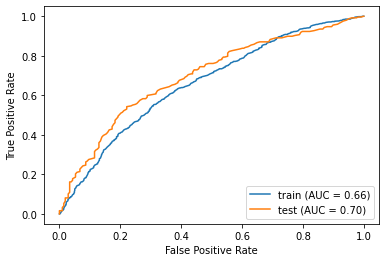

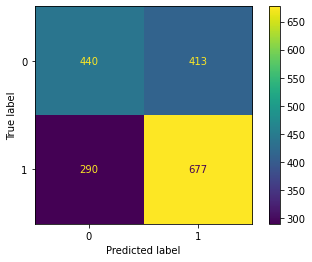

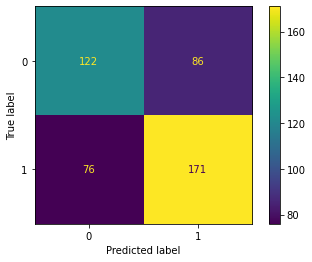

In [38]:
predictions, probabilities=logreg(X_train_best_log,X_test_best_log,y_train,y_test)

In [39]:
new_acc(probabilities)

('New Accuracy: 0.7213740458015268', 'Amount of Games: 189')

## Logistic Regression with PCA

Penalty: l1
Solver: saga
Mean Cross-Val Score: 0.5851648351648351
Train Mean Accuracy: 0.6142857142857143
Test Mean Accuracy: 0.654945054945055
Recall Score: 0.7530364372469636
Precision Score: 0.6595744680851063
F1 Score: 0.7032136105860113


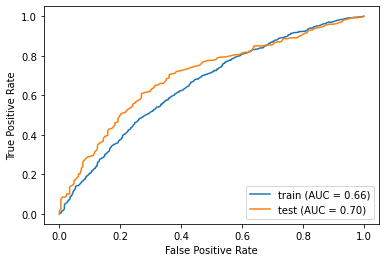

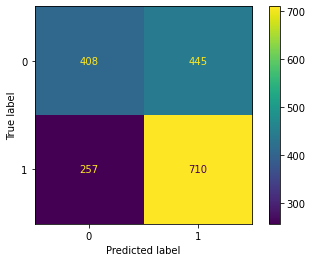

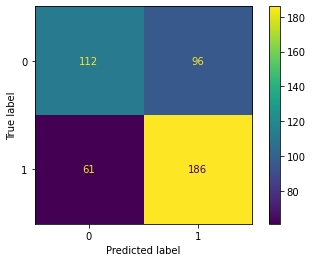

In [44]:
predictions, probabilities=logreg(train_pca_w_scale,test_pca_w_scale,y_train,y_test)

In [45]:
new_acc(probabilities)

('New Accuracy: 0.7130044843049327', 'Amount of Games: 159')

#### Logistic Regression Recap

Logistic Regression runs very smoothly, relatively quickly and predicts at a fairly high rate. In this exact case it predicts slightly better with RFECV while also predicting more games than PCA. Neither model is too computationally expensive in this case. 

## KNN

### KNN without PCA

Number of Neighbors: 17
Metric: manhattan
Weights: uniform
Mean Cross-Val Score: 0.5741758241758241
Train Mean Accuracy: 0.6395604395604395
Test Mean Accuracy: 0.654945054945055
Recall Score: 0.7530364372469636
Precision Score: 0.6595744680851063
F1 score: 0.7032136105860113


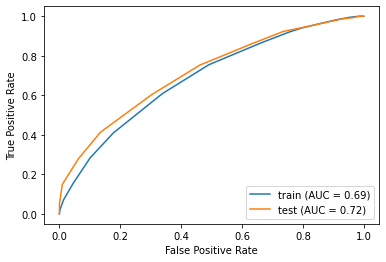

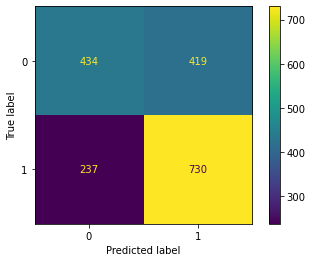

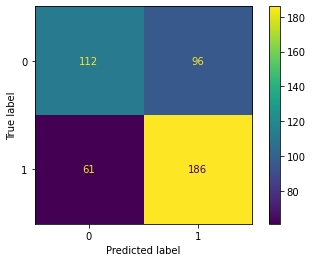

In [46]:
prediction,probabilities=knn(X_train_scaled,X_test_scaled,y_train,y_test)

In [47]:
new_acc(probabilities)

('New Accuracy: 0.7696078431372549', 'Amount of Games: 157')

### KNN with PCA

Number of Neighbors: 15
Metric: minkowski
Weights: uniform
Mean Cross-Val Score: 0.5681318681318681
Train Mean Accuracy: 0.6357142857142857
Test Mean Accuracy: 0.6505494505494506
Recall Score: 0.7246963562753036
Precision Score: 0.662962962962963
F1 score: 0.6924564796905222


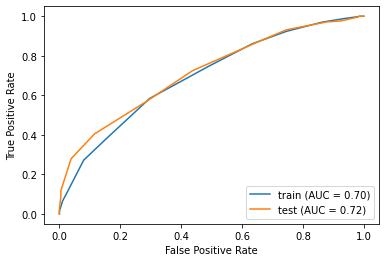

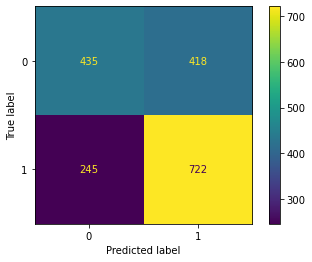

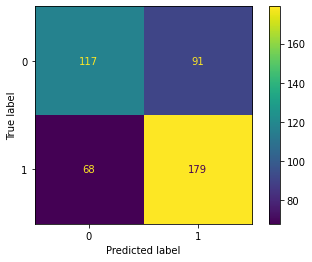

In [48]:
prediction,probabilities=knn(train_pca_w_scale,test_pca_w_scale,y_train,y_test)

In [49]:
new_acc(probabilities)

('New Accuracy: 0.788659793814433', 'Amount of Games: 153')

#### KNN Recap

In this exact case of KNN it predicts a better score using PCA while also predicting two less games. Neither model is too computationally expensive in this case, however PCA is still faster and has the better score so PCA will get the edge.


## Decision Tree

### Decision Tree RFECV

In [52]:
dfeats= feature_select(X_train,y_train,DecisionTreeClassifier,min_features=10)
X_train_best_tree = X_train[dfeats]
X_test_best_tree = X_test[dfeats]

Max Depth: 3
Min Sample Split: 2
criterion: entropy
Mean Cross-Val Score: 0.5967032967032967
Train Mean Accuracy: 0.6192307692307693
Test Mean Accuracy: 0.6395604395604395
Recall Score: 0.631578947368421
Precision Score: 0.6812227074235808
F1 score: 0.6554621848739496


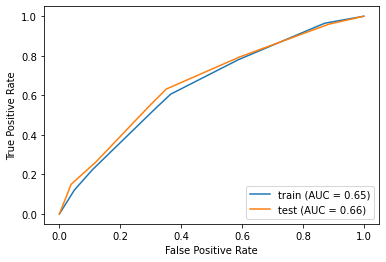

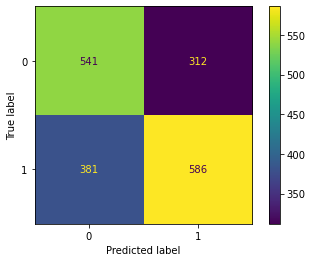

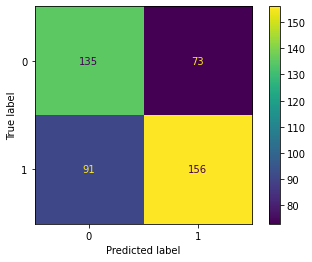

In [53]:
predictions,probabilities=dtree(X_train_best_tree,X_test_best_tree,y_train,y_test)

In [54]:
new_acc(probabilities)

('New Accuracy: 0.6844106463878327', 'Amount of Games: 180')

### Decision Tree with PCA

Max Depth: 3
Min Sample Split: 2
criterion: entropy
Mean Cross-Val Score: 0.5587912087912088
Train Mean Accuracy: 0.5978021978021978
Test Mean Accuracy: 0.6263736263736264
Recall Score: 0.8097165991902834
Precision Score: 0.6191950464396285
F1 score: 0.7017543859649124


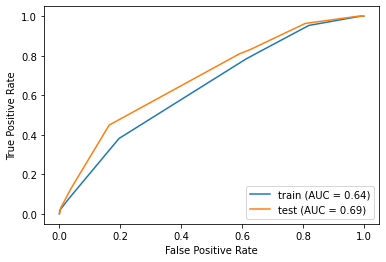

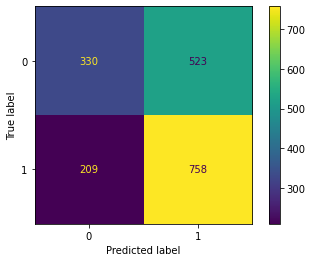

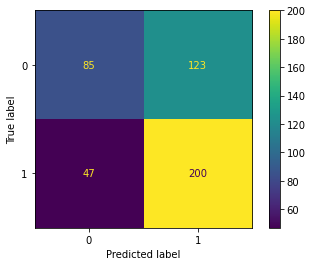

In [100]:
predictions,probabilities=dtree(train_pca_wo_scale,test_pca_wo_scale,y_train,y_test)

Before looking at new accuracy score, using all the games in 2019 the Decison Tree with PCA has a test accuracy of 60.0% and a cross validation score of 58.0%

In [101]:
new_acc(probabilities)

('New Accuracy: 0.7783505154639175', 'Amount of Games: 151')

#### Decision Tree Recap

In this case PCA performs much better than RFECV however it is also more picky. This is a balance that needs to be taken into account when deciding what model to use. Over the course of the project as a whole though Decision Trees have proven to not be as consistently accurate as some of the other models.

## Random Forest

### Random Forest with RFECV

In [57]:
rfeats= feature_select(X_train,y_train,RandomForestClassifier,min_features=10)
X_train_best_for = X_train[rfeats]
X_test_best_for = X_test[rfeats]

Number of Trees: 110
criterion: gini
Mean Cross-Val Score: 0.5653846153846154
Train Mean Accuracy: 0.7098901098901099
Test Mean Accuracy: 0.7230769230769231
Recall Score: 0.728744939271255
Precision Score: 0.7531380753138075
F1 score: 0.7407407407407407


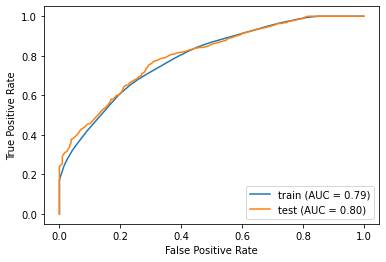

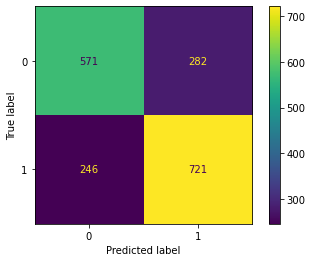

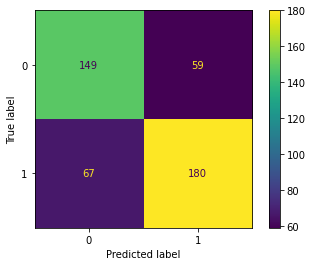

In [58]:
predictions,probabilities=random_forest(X_train_best_for,X_test_best_for,y_train,y_test)

In [59]:
new_acc(probabilities)

('New Accuracy: 0.764367816091954', 'Amount of Games: 266')

### Random Forest with PCA

Number of Trees: 150
criterion: gini
Mean Cross-Val Score: 0.5461538461538462
Train Mean Accuracy: 0.7098901098901099
Test Mean Accuracy: 0.7230769230769231
Recall Score: 0.728744939271255
Precision Score: 0.7531380753138075
F1 score: 0.7407407407407407


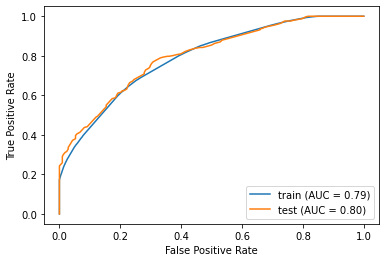

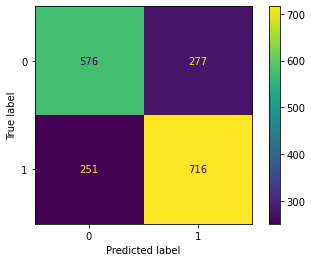

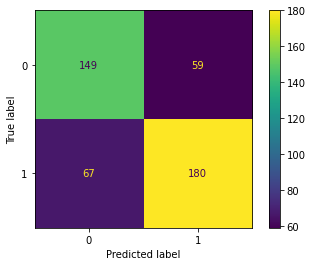

In [102]:
predictions,probabilities=random_forest(train_pca_wo_scale,test_pca_wo_scale,y_train,y_test)

In [103]:
new_acc(probabilities)

('New Accuracy: 0.7670454545454546', 'Amount of Games: 270')

#### Random Forest Recap

Random Forest can be an award winning model and is very popular in competitions for good reason. In this exact case it is nearly identical in accuracy  and it also picks four more games than RFECV when using PCA. Again PCA is also less computationally expensive so whenever I do not need to sacrafice accuracy/amount of games too much it is best to use PCA.

## Bagging

### Bagging without PCA

Dec Tree Max Depth: 5
Dec Tree Criterion: gini
Bagging Max Samples: 5
Bag Max Features: 5
# of Base Estimators: 500
Mean Cross-Val Score: 0.5978021978021978
Train Mean Accuracy Score: 0.6043956043956044
Test Mean Accuracy Score: 0.6285714285714286
Recall Score: 0.8744939271255061
Precision Score: 0.6101694915254238
F1 score: 0.7188019966722131


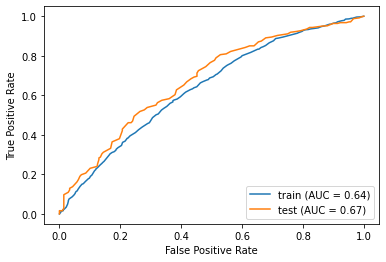

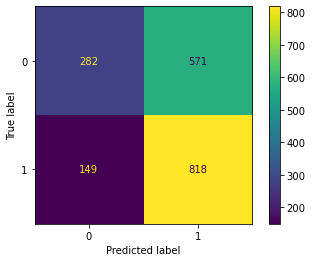

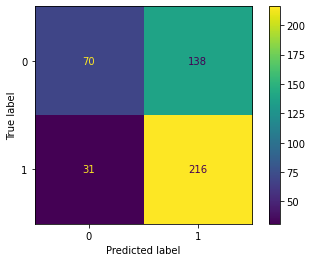

In [62]:
predictions, probabilities = bagged(X_train,X_test,y_train,y_test)

In [63]:
new_acc(probabilities)

('New Accuracy: 0.875', 'Amount of Games: 21')

### Bagging with PCA

Dec Tree Max Depth: 2
Dec Tree Criterion: gini
Bagging Max Samples: 5
Bag Max Features: 3
# of Base Estimators: 500
Mean Cross-Val Score: 0.5543956043956044
Train Mean Accuracy Score: 0.5406593406593406
Test Mean Accuracy Score: 0.5560439560439561
Recall Score: 1.0
Precision Score: 0.5501113585746102
F1 score: 0.7097701149425287


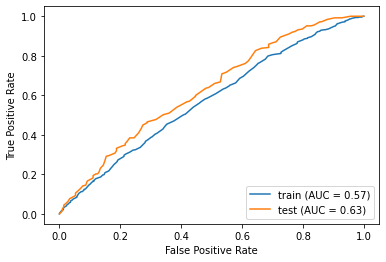

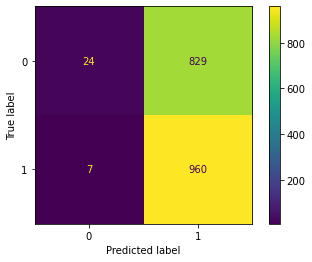

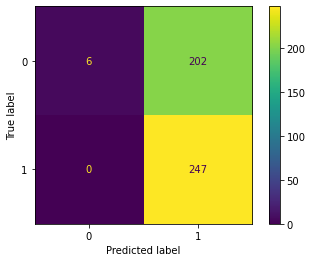

In [104]:
predictions, probabilities = bagged(train_pca_wo_scale,test_pca_wo_scale,y_train,y_test)

In [106]:
#new_acc(probabilities) cannot be run because it does not pick any games with these parameters

#### Bagging Recap

The Bagging Classifier can often take a long time to run as it is very computationally expensive. In this case it is also very accurate however also extremely picky. Using RFECV it has 87.5% accuracy on the adjusted score which is far superior to that of the other models. However, this may not be all that valuable considering it only decided to pick a mere 15 games. This particular nature of the model is seen again in PCA except in this instance it does not choose a single game. 

## XGBoost

### XGBoost with RFECV

In [67]:
xfeats= feature_select(X_train,y_train,XGBClassifier,min_features=10)
X_train_best_x = X_train[xfeats]
X_test_best_x = X_test[xfeats]

XGBoost Learning Rate: 0.05
XGBoost Max Depth: 3
XGBoost Min Child Weight: 1
XGBoost Subsample: 0.7
XGBoost Estimators: 100
Stopped in Round: 15
Mean Cross-Val Score: 0.55
Train Mean Accuracy Score: 0.7098901098901099
Test Mean Accuracy Score: 0.734065934065934
Recall Score: 0.7408906882591093
Precision Score: 0.7625
F1 score: 0.7515400410677617


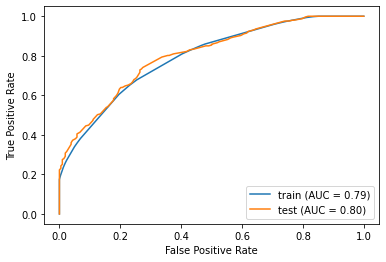

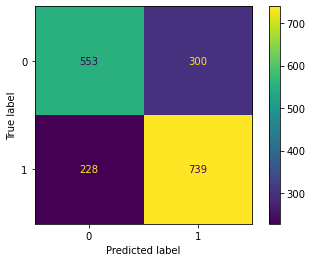

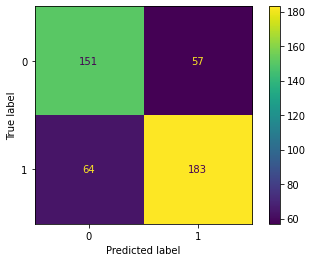

In [68]:
predictions, probabilities= xgboost(X_train_best_x, X_test_best_x, y_train, y_test, cv=5)

In [69]:
new_acc(probabilities)

('New Accuracy: 0.7675070028011205', 'Amount of Games: 274')

### XGBoost with PCA

XGBoost Learning Rate: 0.05
XGBoost Max Depth: 3
XGBoost Min Child Weight: 1
XGBoost Subsample: 0.7
XGBoost Estimators: 100
Stopped in Round: 15
Mean Cross-Val Score: 0.537912087912088
Train Mean Accuracy Score: 0.7098901098901099
Test Mean Accuracy Score: 0.7274725274725274
Recall Score: 0.7530364372469636
Precision Score: 0.7469879518072289
F1 score: 0.75


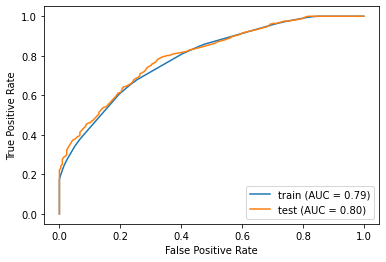

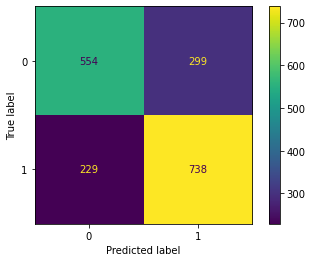

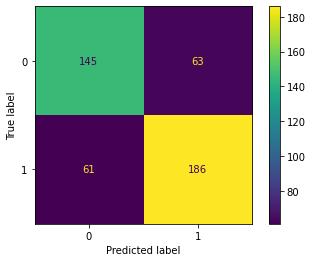

In [107]:
predictions, probabilities= xgboost(train_pca_wo_scale, test_pca_wo_scale, y_train, y_test, cv=5)

In [108]:
new_acc(probabilities)

('New Accuracy: 0.7670454545454546', 'Amount of Games: 270')

#### XGBoost Recap

XGBoost is another very powerful model that comes with the price of being extremely computationally expensive. In this case the accuracy score is solid and is similar whether I use RFECV or PCA and the amount of games is comparable as well. However the value of PCA can be seen very clearly here as running the model using RFECV took nearly 41 minutes while using PCA took only 14. This stark difference shows how valuable PCA can be.

## Model Comparisons

As was stated before I have run these models on many different years and in doing so I was first able to focus in on three models. Logistic Regression, KNN and Random Forest. The reason these three were chosen is a combination of accuracy scores, amounts of games chosen and the computational cost aligned with each model.

![image](https://user-images.githubusercontent.com/73855593/150588369-0de37693-8290-4fad-9047-a75de533c171.png)

![image](https://user-images.githubusercontent.com/73855593/150588890-806a7b8f-d775-4851-a20f-3d87be1a23ba.png)

After analyzing the three of these models over a six year period of time, the last two being heavily affected by COVID-19, it is found that Random Forest is consistently picking games with the highest accuracy while also picking the highest quantity of games. The question then needs to be narrowed down further. Which Random Forest is the best one to use? Is it Random Forest using RFECV or Random Forest using PCA? I decided to chart the two of those over the six year period to see if there are any major differences, that chart can be seen below.

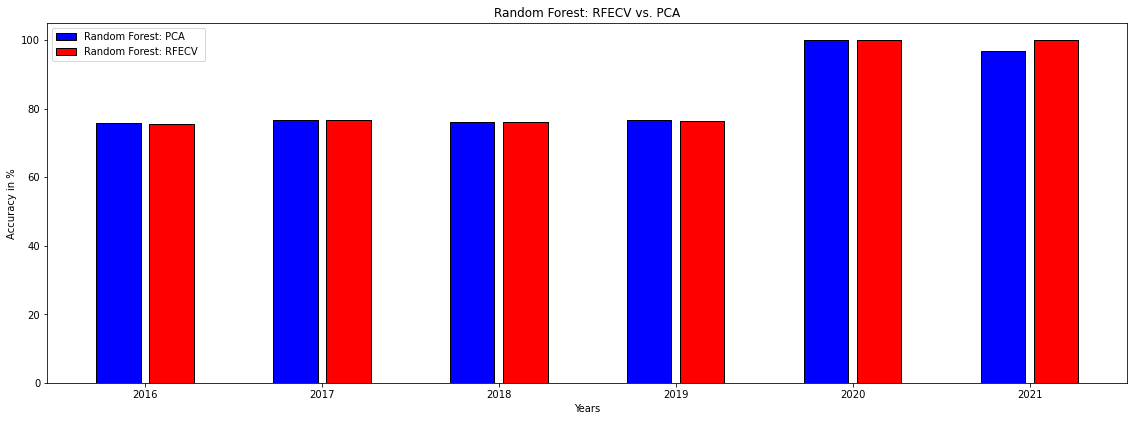

After charting Random Forest PCA v Random Forest RFECV it seems that their accuracy scores are quite similar and nearly identical most years. Therefore I am inclined to lean towards using PCA as it is far less computationally expensive.

In [110]:
# Mean Accuracy of Random Forest using PCA
rf_pca_acc=[75.3,76.8,76.1,76.6,90.5,100.0]
print(f'Mean Adjusted Accuracy : {np.mean(rf_pca_acc)}%')

Mean Adjusted Accuracy : 82.55%


# Conclusion

The results of the Random Forest using PCA while training on the first 75% of games and testing on last 25% are quite encouraging.

The baseline which was predicting the home team to win every game was around 54%, the lowest for any of the four major professional sports. Therefore our new accuracy score of 83.67% far outperforms the baseline. This will allow our stakeholders to do what very few can and that is turn a profit betting on Major League Baseball!

#### Next Steps:
In order to further continue developing our model we could:
- Integrate moneylines to further identify value, 
- Incorporate more player-specific data to predict how a player will affect team performance on a given day especially within starting pitching.
- And finally adjusting bet sizing, in order to maximize risk adjusted returns. 
